Ideas:

1. Physics simulator with mechanics (blocks) from images and rotating bodies (&their images)
2. GridWorld go to goal, with few obstacles (so that the resulting fcn is simple)

In [401]:
from copy import deepcopy
import numpy as np
import math
from webcolors import name_to_rgb
from matplotlib import pyplot as plt
import cv2

In [498]:
def inrange(x, m, M):
    return m <= x <= M

class KeyChestEnvironment(object):
    OBJECTS = ['empty', 'wall', 'key', 'chest', 'food', 'lamp_on', 'lamp_off', 'player']
    SYMBOLS = {'wall': '#', 'player': 'P', 'key': '<', 'chest': '>', 'food': '@',
               'lamp_on': 'L', 'lamp_off': 'l', 'empty': ' '}
    SYMBOLS_TO_OBJECTS = {y: x for x, y in SYMBOLS.items()}
    SYMBOL_LIST = [KeyChestEnvironment.SYMBOLS[x] for x in KeyChestEnvironment.OBJECTS]
    COLORS = {'empty': (191, 191, 191), 'wall': (0, 0, 0), 'key': (0, 0, 255), 'chest': (255, 255, 0), 'lamp_on': (255, 255, 255),
              'lamp_off': (94, 94, 94), 'food': (0, 255, 0), 'player': (255, 0, 0)}
    SYMBOLS_TO_COLORS = {x: KeyChestEnvironment.COLORS[env.SYMBOLS_TO_OBJECTS[x]] for x in KeyChestEnvironment.SYMBOL_LIST}
    
    ACTIONS = {0: (1, 0), 1: (-1, 0), 2: (0, 1), 3: (0, -1)}
    ACTION_NAMES = {(1, 0): "up", (-1, 0): "down", (0, 1): "right", (0, -1): "left"}
    
    def __init__(self, labyrinth_maps, initial_health, food_efficiency,
                 food_rows=None, keys_rows=None, callback=None):
        """Environment with keys and chests."""
        self.initial_maps = deepcopy(labyrinth_maps)
        self.maps = deepcopy(labyrinth_maps)
        self.shape = self.maps[self.SYMBOLS['empty']].shape
        assert set(self.maps.keys()) == set(KeyChestEnvironment.SYMBOLS.values())
        self.keys = 0
        self.food_efficiency = food_efficiency
        self.food_rows = food_rows
        self.keys_rows = keys_rows
        self.initial_health = initial_health
        self.health = initial_health
        self.width = self.shape[1]
        self.height = self.shape[0]
        self.first_render = True
        self.callback_ = callback
        
        # to see if everything fits
        self.render()
        
        self.moves = 0
        self.history = []
        
        self.callback(dict(event='initialized'))
        
    def callback(self, *args, **kwargs):
        if self.callback_:
            self.callback_(*args, moves=self.moves, **kwargs)
        else:
            pass
        self.history.append(dict(args=args, kwargs=kwargs, moves=self.moves))
        
    @property
    def player_position(self):
        return self.locate_single(self.SYMBOLS['player'])
        
    def items_at_position(self, pos):
        """Which items are at a particular position?"""
        return [x for x in self.SYMBOL_LIST if self.maps[x][pos[0], pos[1]]]
    
    def item_at_position(self, pos):
        """Got one item at a position."""
        items = self.items_at_position(pos)
        if len(items) == 2 and self.SYMBOLS['empty'] in items:
            del items[items.index(self.SYMBOLS['empty'])]
        assert len(items) == 1, f"Must have one items only at {pos}, got {items}"
        return items[0]
    
    @property
    def observation(self):
        sx, sy = self.shape
        
        if self.first_render:
            maxfood = self.initial_health + self.food_efficiency * np.sum(self.initial_maps[self.SYMBOLS['food']])
            maxkeys = np.sum(self.initial_maps[self.SYMBOLS['key']])
            food_rows = round(math.ceil(1. * maxfood / (2 + self.width)))
            keys_rows = round(math.ceil(1. * maxkeys / (2 + self.width)))

            if self.food_rows is None:
                self.food_rows = food_rows
            else:
                assert self.food_rows >= food_rows

            if self.keys_rows is None:
                self.keys_rows = keys_rows
            else:
                assert self.keys_rows >= keys_rows
                
            print(self.keys_rows, self.food_rows)
            self.first_render = False
        
        dy1 = 1
        dy2 = 1
        dy = dy1 + dy2
        dx1 = 1 + self.food_rows + self.keys_rows
        dx2 = 1
        dx = dx1 + dx2
        
        def fill_n(arr, offset_x, value, symbol):
            value_left = value
            width = arr.shape[1]
            current_row = offset_x
            while value_left:
                add_this_iter = min(width, value_left)
                arr[current_row, :add_this_iter] = [symbol] * add_this_iter
                current_row += 1
                value_left -= add_this_iter
        
                
        shape = (sx + dx, sy + dy)
        out = np.full(fill_value=self.SYMBOLS['empty'], shape=shape, dtype='<U1')
        
        fill_n(out, 0, self.health, self.SYMBOLS['food'])
        fill_n(out, self.food_rows, self.keys, self.SYMBOLS['key'])
        
        out[dx1 - 1, :] = self.SYMBOLS['wall']
        out[-1, :] = self.SYMBOLS['wall']
        out[dx1 - 1:, 0] = self.SYMBOLS['wall']
        out[dx1 - 1:, -1] = self.SYMBOLS['wall']
        for obj in self.OBJECTS:
            symb = self.SYMBOLS[obj]
            mask = self.maps[symb] > 0
            out[dx1:-dx2,dy1:-dy2][mask] = self.SYMBOLS[obj]
            
        return out
        
    def move_symbol(self, symbol, old_pos, new_pos):
        self.delete_symbol(symbol, old_pos)
        self.add_symbol(symbol, new_pos)
        
    def delete_symbol(self, symbol, old_pos):
        assert self.maps[symbol][old_pos[0], old_pos[1]]
        self.maps[symbol][old_pos[0], old_pos[1]] = False
        
    def add_symbol(self, symbol, new_pos):
        assert not self.maps[symbol][new_pos[0], new_pos[1]]
        self.maps[symbol][new_pos[0], new_pos[1]] = True
        
    def step(self, action):
       
        info = {'action': action, 'event': 'regular_move'}
        
        next_position = np.array(self.player_position) + np.array(self.ACTIONS[action])
        if not inrange(next_position[0], 0, self.height - 1):
            info['event'] = 'bump_top_or_bottom'
        elif not inrange(next_position[1], 0, self.width - 1):
            info['event'] = 'bump_left_or_right'
        else:
            # otherwise we are moving
            item = self.item_at_position(next_position)

            if item == self.SYMBOLS['wall']:
                info['event'] = 'bump_wall'

            if item == self.SYMBOLS['lamp_on']:
                self.delete_symbol(self.SYMBOLS['lamp_on'], next_position)
                self.add_symbol(self.SYMBOLS['lamp_off'], next_position)
                info['event'] = 'lamp_turned_off'
            elif item == self.SYMBOLS['lamp_off']:
                self.delete_symbol(self.SYMBOLS['lamp_off'], next_position)
                self.add_symbol(self.SYMBOLS['lamp_on'], next_position)
                info['event'] = 'lamp_turned_on'
            elif item == self.SYMBOLS['food']:
                self.delete_symbol(self.SYMBOLS['food'], next_position)
                self.health += self.food_efficiency
                info['event'] = 'food_collected'
            elif item == self.SYMBOLS['key']:
                self.delete_symbol(self.SYMBOLS['key'], next_position)
                self.keys += 1
                info['event'] = 'key_collected'
            elif item == self.SYMBOLS['chest']:
                if self.keys > 0:
                    self.keys -= 1
                    self.delete_symbol(self.SYMBOLS['chest'], next_position)
                    info['event'] = 'chest_opened'
                else:
                    info['event'] = 'not_enough_keys'
            else:
                info['event'] = 'regular_move'

            self.move_symbol(self.SYMBOLS['player'], self.player_position, next_position)
        
        self.callback(info)
        self.moves += 1
        return self.observation
        
        
    def render(self, mode='np_array'):
        obs = self.observation
        
        if mode == 'np_array':
            return obs
        elif mode == 'str':
            return '\n'.join([''.join(x) for x in obs])
        elif mode == 'rgb_array':
            
            out_arr = np.zeros((obs.shape[0], obs.shape[1], 3))
            for symbol in self.SYMBOL_LIST:
                mask = arr == symbol
                out_arr[mask] = self.SYMBOLS_TO_COLORS[symbol]
            out_arr /= 255.

            out_arr = np.repeat(out_arr, scale, axis=1)
            out_arr = np.swapaxes(np.repeat(np.swapaxes(out_arr, 0, 1), scale, axis=1), 0, 1)
            return out_arr
        
        return obs
        
    def locate(self, object_type):
        return KeyChestEnvironment._locate(self.maps, object_type)
    
    def locate_single(self, object_type):
        return KeyChestEnvironment._locate_single(self.maps, object_type)
    
    @staticmethod
    def _locate(maps, object_type):
        """Where are objects of a given type on the map?"""
        assert object_type in KeyChestEnvironment.SYMBOLS.values(), \
            f"Wrong object {object_type}, have {maps.keys()}"
        return list(zip(*np.where(maps[object_type])))
    
    @staticmethod
    def _locate_single(maps, object_type):
        """Where is the single object?"""
        w = KeyChestEnvironment._locate(maps, object_type)
        assert len(w) >= 1, f"No {object_type} found"
        assert len(w) <= 1, f"More than one {object_type} found"
        return w[0]

In [499]:
class KeyChestEnvironmentRandom(KeyChestEnvironment):
    
    def __init__(self, width=10, height=10, n_keys=2, n_chests=2, n_food=2, **kwargs):
        objects_to_fill = ['player', 'lamp_off']
        objects_to_fill += ['key'] * n_keys
        objects_to_fill += ['chest'] * n_chests
        objects_to_fill += ['food'] * n_food
        shape = (height, width)
        wh = width * height
        assert wh >= len(objects_to_fill)
        
        positions = []
        for i in range(height):
            for j in range(width):
                positions.append((i, j))
                
        pos_select = np.random.choice(range(len(positions)), len(objects_to_fill), replace=False)
        
        maps = {k: np.zeros(shape, dtype=np.bool) for k in self.SYMBOLS.values()}
        maps[self.SYMBOLS['empty']][:,:] = True
                
        for pos, obj in zip(pos_select, objects_to_fill):
            m = maps[self.SYMBOLS[obj]]
            p = positions[pos]
            m[p[0], p[1]] = True
        
        super(KeyChestEnvironmentRandom, self).__init__(labyrinth_maps=maps, **kwargs)

In [500]:
def callback_print(x, moves=None):
    print(moves, x)

In [501]:
env = KeyChestEnvironmentRandom(initial_health=13, food_efficiency=10, callback=callback_print)

1 3
0 {'event': 'initialized'}


In [505]:
_ = env.step(0)

1 {'action': 0, 'event': 'regular_move'}


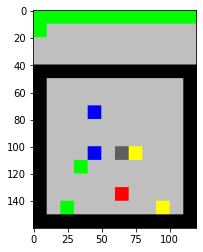

In [506]:
plt.imshow(env.render('rgb_array'))

In [495]:
env.step(0)

0 {'action': 0, 'event': 'regular_move'}


array([['@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@'],
       ['@', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       ['#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '>', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '<', '@', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', '>', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', '@', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'l', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'P', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', '

In [424]:
print(env.render('str'))

@@@@@@@@@@@@
@           
            
            
############
#          #
#          #
#   <      #
#          #
#          #
#   < l>   #
#  @       #
#          #
#     P    #
# @      > #
############


In [425]:
arr = env.observation

In [448]:
env.SYMBOLS_TO_COLORS

{' ': (191, 191, 191),
 '#': (0, 0, 0),
 '<': (0, 0, 255),
 '>': (255, 255, 0),
 '@': (0, 255, 0),
 'L': (255, 255, 255),
 'l': (125, 125, 125),
 'P': (255, 0, 0)}

In [487]:
scale = 10

In [496]:
env

AttributeError: 'KeyChestEnvironmentRandom' object has no attribute 'reset'

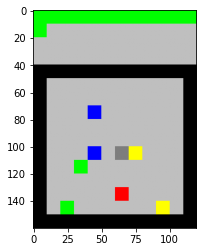

In [414]:
arr = np.array([[1,2,3],
         [4,5,6]])
arr

array([[1, 2, 3],
       [4, 5, 6]])

array([[1, 1, 2, 2, 3, 3],
       [4, 4, 5, 5, 6, 6]])